Para este análisis se usó un conjunto de datos en el que se detallan los obsequios a funcionarios públicos registrados en el ámbito de la Oficina Anticorrupción.
Fuente: https://datos.gob.ar/dataset/justicia-registro-obsequios-funcionarios-publicos

In [14]:
import io
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
from spacy.lang.es import Spanish
from spacy.lang.es.stop_words import STOP_WORDS
from wordcloud import WordCloud

In [15]:
data = pd.read_csv("./data/registro-obsequios-funcionarios-publicos-20201009.csv")
print('Cantidad de registros cargados: {}'.format(len(data)))
print(data.head())

Cantidad de registros cargados: 3928
                  expediente funcionario_nombre_completo  \
0  RL-2017-1920930-APN-OA#MJ               Leonardo Hugo   
1  RL-2017-1967319-APN-OA#MJ                       Laura   
2  RL-2017-1994454-APN-OA#MJ                        Mora   
3  RL-2017-2057755-APN-OA#MJ                   Christian   
4  RL-2017-2082409-APN-OA#MJ                       Laura   

  funcionario_apellido_completo  funcionario_cuil  \
0                      Limanski      2.032953e+10   
1                        Alonso      2.723121e+10   
2                        Kantor      2.728694e+10   
3                         Ramos      2.328460e+10   
4                        Alonso      2.723121e+10   

                    funcionario_jurisdiccion  \
0  Ministerio de Justicia y Derechos Humanos   
1  Ministerio de Justicia y Derechos Humanos   
2  Ministerio de Justicia y Derechos Humanos   
3                Ministerio de Modernización   
4  Ministerio de Justicia y Derechos Humano

In [16]:
# clean and unify features
data["funcionario_nombre"] = data["funcionario_nombre_completo"] + " " + data["funcionario_apellido_completo"]
data["obsequiador_cargo_representante"] = data["obsequiador_cargo_representante"].str.lower()
data["obsequio_descripcion"] = data["obsequio_descripcion"].str.lower()

In [17]:
data[["obsequio_tipo"]].value_counts()

obsequio_tipo                    
Otros                                910
Libros                               907
Objetos en general                   734
Alimentos                            713
Artesanías (productos regionales)    335
Indumentaria                         197
Obras de arte                         70
Joyería y relojería                   39
Electrónicos                          19
Mobiliario                             4
dtype: int64

In [18]:
data[data["obsequio_tipo"]=="Otros"].obsequio_descripcion.head(10)

7     dos entradas al concierto de elena rogers en c...
21                pañuelo de mujer, de seda, estampado.
32    una (1) fotografía de ss.mm. los reyes de espa...
36    un (1) cd del concierto ofrecido por la unidad...
37    un (1) álbum de fotos de la visita de estado a...
38             una (1) medalla institucional en estuche
39             una (1) medalla institucional en estuche
54    un (1) dvd documental de cruz ortiz: "el nuevo...
55    una (1) remera del centro gallego de buenos aires
56       un (1) par de alpargatas del club boca juniors
Name: obsequio_descripcion, dtype: object

In [19]:
gifts_by_value = data[["obsequio_valor_estimado","obsequio_tipo"]].groupby("obsequio_valor_estimado").count().sort_values("obsequio_tipo", ascending=False)
print("Valor aproximado de 4 módulos: $4.000")
print(gifts_by_value)

Valor aproximado de 4 módulos: $4.000
                                                    obsequio_tipo
obsequio_valor_estimado                                          
Inferior a 4 módulos.                                        3697
Superior a 4 módulos o imposibilidad de determi...            164
Inferior a 4 módulos pero con valor institucion...             67


In [20]:
gifts_by_role = data[["obsequiador_cargo_representante","obsequio_tipo"]].value_counts()
print(gifts_by_role)

obsequiador_cargo_representante           obsequio_tipo                    
presidente                                Alimentos                            70
                                          Libros                               42
                                          Artesanías (productos regionales)    40
                                          Otros                                36
embajador                                 Objetos en general                   32
                                                                               ..
ministro de produccion                    Otros                                 1
ministro de pesca, ganadería y  lechería  Objetos en general                    1
ministro de justicia y ddhh               Libros                                1
ministro de justicia de italia            Otros                                 1
intendente municipal                      Artesanías (productos regionales)     1
Length: 660, dtype: in

In [8]:
gifts_by_role = data[["obsequiador_cargo_representante"]].value_counts()
print(gifts_by_role)

obsequiador_cargo_representante            
presidente                                     232
embajador                                      143
intendente                                      56
director                                        40
ministro                                        37
                                              ... 
ministro de salud de la pcia de corrientes       1
ministro de salud de la pcia. de corrientes      1
ministro de turismo y deportes                   1
ministro de turismo, producción y deportes       1
manager senior                                   1
Length: 511, dtype: int64


In [9]:
gifts_by_date = data[["obsequio_fecha_registro"]].value_counts()
print("Día con más regalos:")
print(gifts_by_date.head(5))
# print("Día con más regalos: {} {}".format(gifts_by_date.idxmax()[0], gifts_by_date.head(1).values))
# print(data.loc[(data["obsequio_fecha_registro"]=="2018-11-16") & (data["obsequio_tipo"]=="Otros"), ["obsequio_descripcion", "obsequio_valor_estimado"]].head(10))

Día con más regalos:
obsequio_fecha_registro
2018-11-16                 69
2017-08-24                 64
2019-01-17                 52
2018-09-27                 47
2019-11-27                 45
dtype: int64


Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)
https://www.argentina.gob.ar/justicia/igj/calculador-modulos
                                   obsequio_descripcion
obsequio_tipo                                          
Objetos en general                                   54
Otros                                                48
Obras de arte                                        22
Joyería y relojería                                  15
Artesanías (productos regionales)                    10
Alimentos                                             6
Libros                                                4
Indumentaria                                          3
Electrónicos                                          1
Mobiliario                                            1


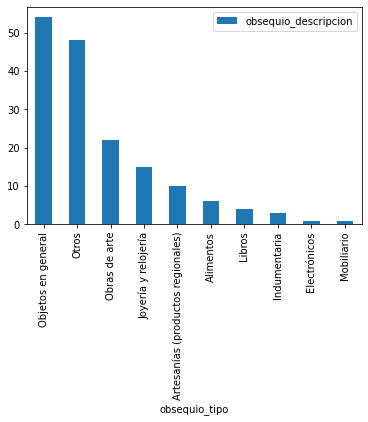

In [10]:
expensive_gifts = data[data.obsequio_valor_estimado=="Superior a 4 módulos o imposibilidad de determinar su valor."]

print("Cantidades de obsequios con un valor mayor a 4 módulos ($4.000)")
print("https://www.argentina.gob.ar/justicia/igj/calculador-modulos")
expensive_gifts_by_type = expensive_gifts[["obsequio_tipo", "obsequio_descripcion"]].groupby("obsequio_tipo").count().sort_values("obsequio_descripcion", ascending=False)

print(expensive_gifts_by_type)
expensive_gifts_by_type.plot(kind = 'bar')
plt.show()

In [11]:
print("Obsequios con un valor mayor a 4 módulos ($4.000)")
expensive_gifts["obsequio_descripcion"]

Obsequios con un valor mayor a 4 módulos ($4.000)


28      bolígrafo - montblanc - pix rollerball blue - ...
65                                              alfombras
104                  alfombra fbmi - modelo sultan mamluk
107      pañuelo hermes 90cm mythiques phoenix coloriages
142     "una (1) tetera de porcelana pintada-cuatro (4...
                              ...                        
3683                                        4 cajas de té
3702                                     bandeja de plata
3703                                        4 cajas de té
3704    caja de lata que contiene: una mascarilla de s...
3709    un mate de calabaza con detalle de alpaca y un...
Name: obsequio_descripcion, Length: 164, dtype: object

In [21]:
# Create a function to clean gift descriptions
def cleanTxt(text):
 text = text.replace("inscripción provisoria por comunicación judicial (causa 9608/18 del juzg fed crim y corr 11) como fecha de recepción se indica la de dicha comunicación",'')
 text = text.replace(" -- ",'')
#  text = text.replace("una",'').replace("un",'')
#  text = re.sub('\((.+)\)', '', text) 
 text = text.strip()
 return text


# Clean gift descriptions
expensive_gifts.obsequio_descripcion = expensive_gifts.obsequio_descripcion.apply(cleanTxt)

print(expensive_gifts.obsequio_descripcion.unique())

['bolígrafo - montblanc - pix rollerball blue - serie 114809 origen: alemania'
 'alfombras' 'alfombra fbmi - modelo sultan mamluk'
 'pañuelo hermes 90cm mythiques phoenix coloriages'
 '"una (1) tetera de porcelana pintada-cuatro (4) tazas sin asa de porcelana pintada-una (1) caramelera de porcelana"'
 'plato de porcelana, elaborado con la técnica de porcelana tierna, material pasta tierna.'
 'cafetera clasica de la hospitaridad arabe presentada en base caoba'
 'cuadro de estilo abstracto'
 'un (1) juego de té de porcelana pintada a mano compuesto por una tetera, un plato y cinco tacitas'
 'un (1) cuadro de singapur en acuarela'
 'un (1) centro de mesa cuadrado de vidrio con flores'
 'una (1) fuente de metal plateado con la casa blanca grabada'
 'un (1) cuadro de la universidad de pensilvania'
 'un (1) cuadro de vidrio con la imagen de un caballo'
 'una (1) billetera color bordeaux "salvatore ferragamo"'
 'un (1) marco de cristal con el escudo de la república italiana'
 'una (1) fotogra

In [22]:
#tokenize gifts descriptions and remove spanish stopwords
nlp = Spanish(path=None)

for i in range(len(expensive_gifts)):
  gift = expensive_gifts[["obsequio_descripcion"]].iloc[i][0]
  doc = nlp(gift)
  tokens = [token.text for token in doc if not token.is_stop]
  print(tokens)

['bolígrafo', '-', 'montblanc', '-', 'pix', 'rollerball', 'blue', '-', 'serie', '114809', 'origen', ':', 'alemania']
['alfombras']
['alfombra', 'fbmi', '-', 'modelo', 'sultan', 'mamluk']
['pañuelo', 'hermes', '90', 'cm', 'mythiques', 'phoenix', 'coloriages']
['"', '(', '1', ')', 'tetera', 'porcelana', 'pintada-cuatro', '(', '4', ')', 'tazas', 'asa', 'porcelana', 'pintada-una', '(', '1', ')', 'caramelera', 'porcelana', '"']
['plato', 'porcelana', ',', 'elaborado', 'técnica', 'porcelana', 'tierna', ',', 'material', 'pasta', 'tierna', '.']
['cafetera', 'clasica', 'hospitaridad', 'arabe', 'presentada', 'base', 'caoba']
['cuadro', 'estilo', 'abstracto']
['(', '1', ')', 'juego', 'té', 'porcelana', 'pintada', 'a', 'mano', 'compuesto', 'tetera', ',', 'plato', 'y', 'tacitas']
['(', '1', ')', 'cuadro', 'singapur', 'acuarela']
['(', '1', ')', 'centro', 'mesa', 'cuadrado', 'vidrio', 'flores']
['(', '1', ')', 'fuente', 'metal', 'plateado', 'casa', 'blanca', 'grabada']
['(', '1', ')', 'cuadro', 'uni

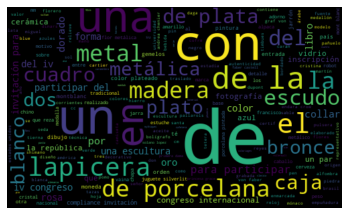

In [23]:
# word cloud visualization
# TODO debería usar cada elemento de la lista de token como un todo, por ej: "['baul', ''madera]" deberia ser la "palabra" baul madera a usar en la nube de palabras
allWords = ' '.join([gifts for gifts in expensive_gifts["obsequio_descripcion"]])
# print(allWords)
wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)


plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()